In [1]:
!apt-get install -y git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
! rm -rf NLP-project
! git clone https://github.com/ReviBa/NLP-project
! cp -rf NLP-project/* .

Cloning into 'NLP-project'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 129 (delta 62), reused 85 (delta 26), pack-reused 0
Receiving objects: 100% (129/129), 7.61 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
! pip install --q -r /content/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:

In [4]:
from t5.train import t5_train
from utils.tokens_utils import get_tokenizer_based_on_data, get_max_tokens_number
from context_manager import DialogContextManager
from transformers import T5Tokenizer
from t5.model import T5Model
import pandas as pd
import warnings
import torch

Set warnings filter to ignore:

In [5]:
warnings.filterwarnings('ignore')


In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

In [7]:
MODEL_NAME = "t5-base"
# small batch size because cuda gets out of memory
BATCH_SIZE = 2
PATH = "/content/resources/daily_dialog_for_training.csv"
SAVE_TO_CHECKPOINT = "Option3-trained-on-daily-dialog-splitted-corpus-second-epoch"

In [8]:
train_df = pd.read_csv(PATH)

Add tokens from this dataset that are unknown for T5 tokenizer

In [9]:
cols = ['input', 'target']
train_df =  train_df.rename(columns={'question': cols[0], 'answer': cols[1]})[cols]

In [10]:
tokenizer = get_tokenizer_based_on_data(train_df, *cols)
i_max_token_len, o_max_token_len = get_max_tokens_number(train_df, *cols)

In [ ]:
trained_model, trainer = t5_train(train_df, DEVICE, tokenizer,
                                  MODEL_NAME, i_max_token_len, o_max_token_len, train_batch_size=BATCH_SIZE,
                                  test_batch_size=BATCH_SIZE, epochs=2, save_to_checkpoint=SAVE_TO_CHECKPOINT)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 235 M 
-----------------------------------------------------
235 M     Trainable params
0         Non-trainable params
235 M     Total params
940.152   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Results example

1. Go to https://drive.google.com/drive/folders/1kTAxz5yc7SpmPJ4Q3MabSrXh7RQCCzt4?usp=sharing and make a shortcut from the checkpoint path to your root dir in drive
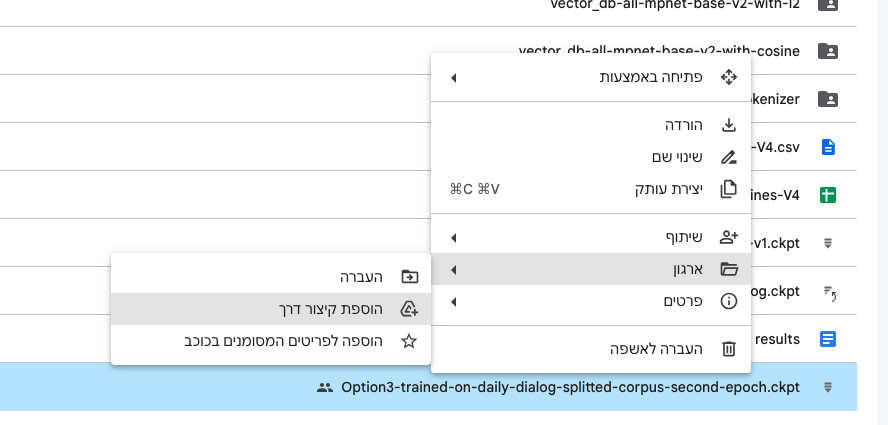

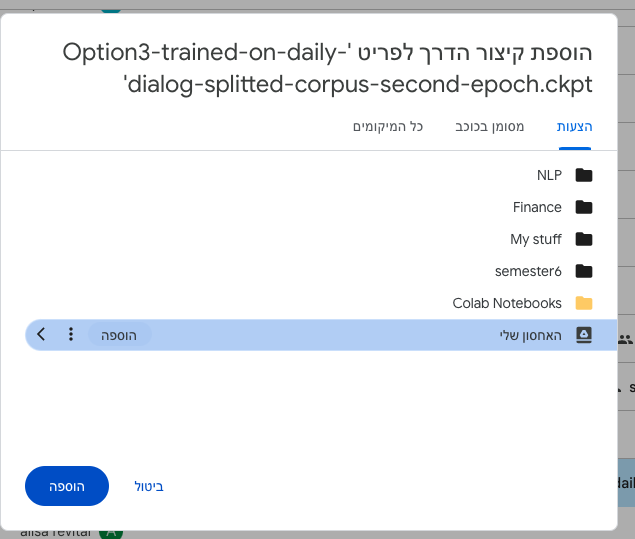

2. checkpoint are saved in google drive, if you wish to load the model you must authorise acsess

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=max(get_max_tokens_number(train_df, cols[0], cols[1])))

In [ ]:
trained_model = T5Model(MODEL_NAME)
checkpoint = torch.load(f'/content/drive/MyDrive/{SAVE_TO_CHECKPOINT}.ckpt')
trained_model.load_state_dict(checkpoint['state_dict'])
trained_model.to(DEVICE)


In [26]:
context_manager = DialogContextManager(trained_model, tokenizer, i_max_token_len, DEVICE)
print(context_manager.write("Hi! how are you?"))

Question: Hi! how are you?
Answer: Person2: I'm fine. How about you?


In [27]:
print(context_manager.write("Actually i'm feeling sick."))

Question: Hi! how are you?
Answer: Person2: I'm fine. How about you?
Question: Actually i'm feeling sick.
Answer: Person2: I'm sorry.


In [30]:
context_manager = DialogContextManager(trained_model, tokenizer, i_max_token_len, DEVICE)
print(context_manager.write("Where do you work?"))

Question: Where do you work?
Answer: Person2: I work in the embassy.


In [31]:
print(context_manager.write("Cool. do you like working there?"))

Question: Where do you work?
Answer: Person2: I work in the embassy.
Question: Cool. do you like working there?
Answer: Person2: Yes, I like working in the embassy.
